# League of Legends PCA Clustering Analysis

This notebook is my attempt at clustering all the champions in League of Legends based on similar stats and appearance. The scripts that were written to acquire this data from the Riot Developer API is also in the same repo. I start this notebook by reading in the csv containing the name, id, tags, info, and stats of all 147 champions in the data.

In [206]:
# importing packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# showing images
import matplotlib.image as mpimg

In [24]:
# reading data
champs_df = pd.read_csv('https://raw.githubusercontent.com/peanutshawny/league-of-legends/master/data/champions.csv')
champs_df.head()

,key,name,id,tags,image,attack,difficulty,magic,defense,armorPerLevel,...,criticalStrikeChancePerLevel,magicResist,attackDamage,attackspeed,healthHegenPerLevel,magicResistPerLevel,manaRegenPerLevel,movespeed,attackDamagePerLevel,manaPerLevel
0,Aatrox,Aatrox,266,"['Fighter', 'Tank']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,8,4,3,4,3.25,...,0.0,32.1,60.0000,0.651,1.00,1.25,0.000,345.0,5.00,0.0
1,Ahri,Ahri,103,"['Mage', 'Assassin']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,3,5,8,4,3.50,...,0.0,30.0,53.0400,0.668,0.60,0.50,0.800,330.0,3.00,25.0
2,Akali,Akali,84,['Assassin'],https://ddragon.leagueoflegends.com/cdn/9.24.2...,5,7,8,3,3.50,...,0.0,37.0,62.4000,0.625,0.50,1.25,0.000,345.0,3.30,0.0
3,Alistar,Alistar,12,"['Tank', 'Support']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,6,7,5,9,3.50,...,0.0,32.1,61.1116,0.625,0.85,1.25,0.800,330.0,3.62,40.0
4,Amumu,Amumu,32,"['Tank', 'Mage']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,2,3,8,6,3.80,...,0.0,32.1,53.3800,0.736,0.85,1.25,0.525,335.0,3.80,40.0


In [25]:
# takes in the dataframe and outputs the count of all unique tags in a dictionary
def num_tags(df):
    tags = df['tags'].tolist()
    # cleaning up strings within each sublist
    clean_tags = []
    for tag in tags:
        clean_tag = tag.replace('[', '').replace(']', '').replace('\'', '')
        clean_tags.append(clean_tag)
    # counting the number of occurances of each combination of tags
    combination_dict = {tag: clean_tags.count(tag) for tag in clean_tags}   
    # flattening all sublists into one list
    clean_tags = [tag.split(',') for tag in clean_tags]
    clean_tags = [tag for subtag in clean_tags for tag in subtag]
    # removing any leading white spaces
    clean_tags = [tag.replace(' ', '') for tag in clean_tags]
    # counting the number of occurances of each tag
    tags_dict = {tag: clean_tags.count(tag) for tag in clean_tags}  
    # converting to dataframe to sort later on
    combination_df = pd.Series(combination_dict).to_frame('frequency')
    combination_df.sort_values(by = 'frequency', ascending = False, inplace = True)
    tags_df = pd.Series(tags_dict).to_frame('frequency')
    tags_df.sort_values(by = 'frequency', ascending = False, inplace = True)  
    # returns list of sorted dataframes
    return [tags_df, combination_df]

In [26]:
# executing function to get combination of tags and frequencies of individual tags
to_plot = num_tags(champs_df)

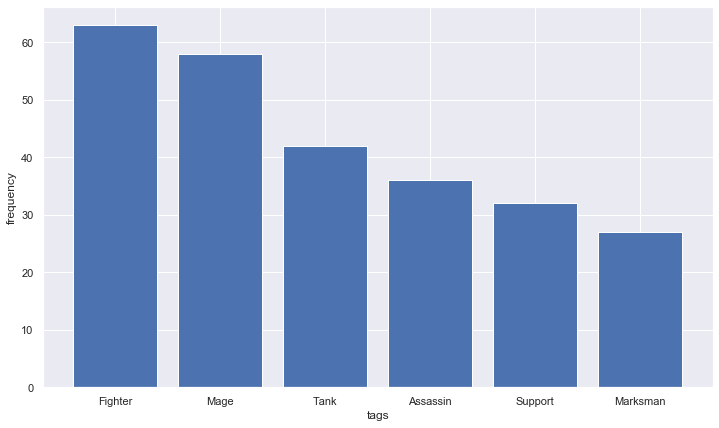

In [141]:
# plotting most common types of combinations of tags
sns.set()
plt.figure(figsize=(12,7))
plt.bar(to_plot[0].index.values, to_plot[0]['frequency'], align = 'center')
plt.xlabel('tags')
plt.ylabel('frequency')

plt.show();

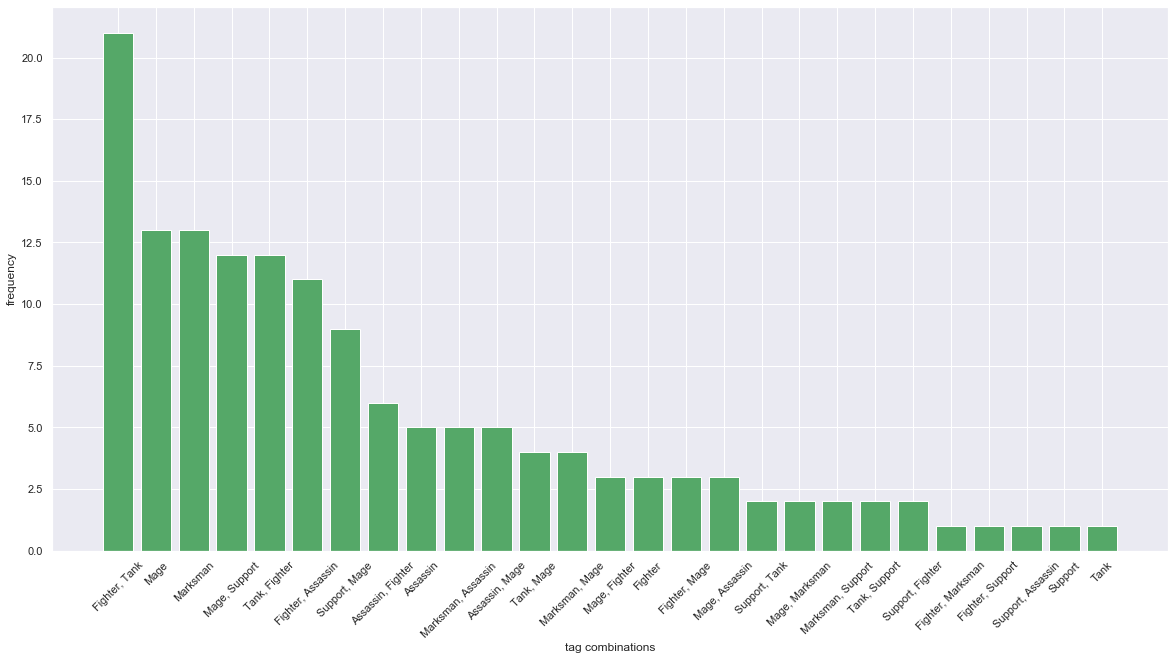

In [143]:
# plotting most common types individuals tags
plt.figure(figsize=(20, 10))
plt.bar(to_plot[1].index.values, to_plot[1]['frequency'], align = 'center', color = 'g')
plt.xticks(rotation = 45)
plt.xlabel('tag combinations')
plt.ylabel('frequency')

plt.show();

In [29]:
# splitting up stats to prepare to pca clustering analysis
champs_df_stats = champs_df.drop(['name', 'id', 'tags', 'image'], axis = 1)

In [30]:
champs_df_stats.head()

,key,attack,difficulty,magic,defense,armorPerLevel,mana,manaRegen,criticalStrikeChance,health,...,criticalStrikeChancePerLevel,magicResist,attackDamage,attackspeed,healthHegenPerLevel,magicResistPerLevel,manaRegenPerLevel,movespeed,attackDamagePerLevel,manaPerLevel
0,Aatrox,8,4,3,4,3.25,0.0,0.000,0.0,580.00,...,0.0,32.1,60.0000,0.651,1.00,1.25,0.000,345.0,5.00,0.0
1,Ahri,3,5,8,4,3.50,418.0,8.000,0.0,526.00,...,0.0,30.0,53.0400,0.668,0.60,0.50,0.800,330.0,3.00,25.0
2,Akali,5,7,8,3,3.50,200.0,50.000,0.0,575.00,...,0.0,37.0,62.4000,0.625,0.50,1.25,0.000,345.0,3.30,0.0
3,Alistar,6,7,5,9,3.50,350.0,8.500,0.0,573.36,...,0.0,32.1,61.1116,0.625,0.85,1.25,0.800,330.0,3.62,40.0
4,Amumu,2,3,8,6,3.80,287.2,7.382,0.0,613.12,...,0.0,32.1,53.3800,0.736,0.85,1.25,0.525,335.0,3.80,40.0


In [31]:
champs_df_stats.columns

Index(['key', 'attack', 'difficulty', 'magic', 'defense', 'armorPerLevel',
       'mana', 'manaRegen', 'criticalStrikeChance', 'health',
       'percentAttackSpeedPerLevel', 'healthPerLevel', 'healthRegen', 'armor',
       'attackRange', 'criticalStrikeChancePerLevel', 'magicResist',
       'attackDamage', 'attackspeed', 'healthHegenPerLevel',
       'magicResistPerLevel', 'manaRegenPerLevel', 'movespeed',
       'attackDamagePerLevel', 'manaPerLevel'],
      dtype='object')

In [218]:
# separating out the features and names, only picking particular features
features = ['difficulty', 'armorPerLevel', 'mana', 'manaRegen',
           'health', 'percentAttackSpeedPerLevel', 'healthPerLevel','healthRegen', 'attackRange',
            'attackDamage', 'attackspeed', 'healthHegenPerLevel',
           'magicResistPerLevel', 'manaRegenPerLevel', 'movespeed', 'attackDamagePerLevel', 'manaPerLevel']
x = champs_df_stats.loc[:, features]
y = champs_df_stats.loc[:, ['key']]

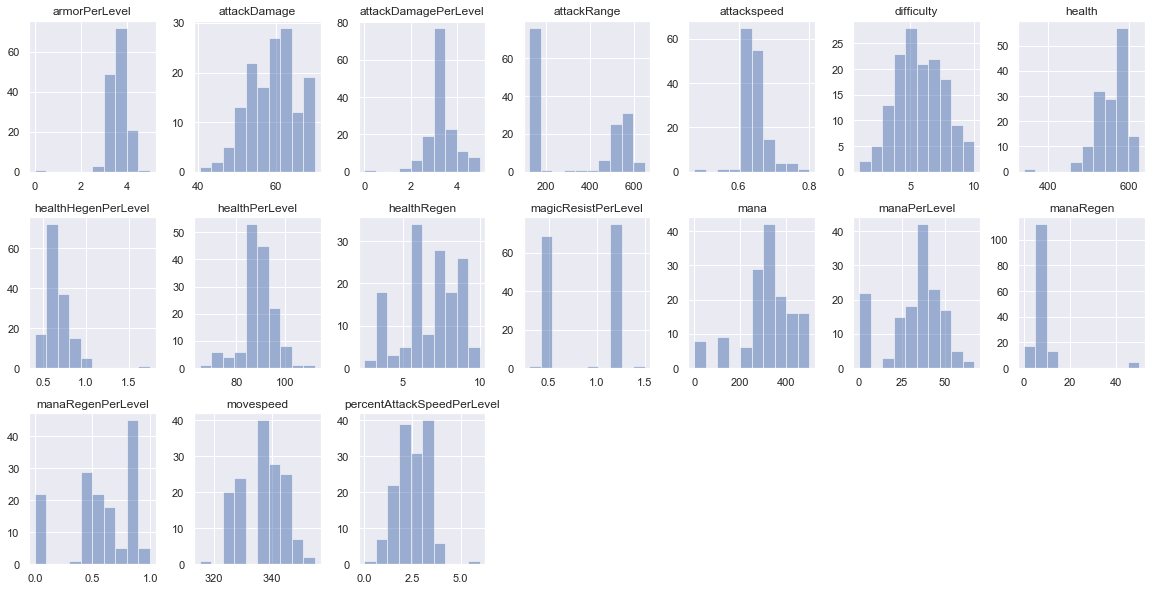

In [219]:
# creating histograms to take a look at distribution of stats
x.hist(figsize = (20, 10), layout = (3,7), alpha = 0.5);

In [220]:
# standardizing the features
x_minmax = MinMaxScaler().fit_transform(x)

# pca projection into 2D
pca = PCA(n_components = 2)
principal_components_minmax = pca.fit_transform(x_minmax)

# explained variance ratio
print(pca.explained_variance_ratio_)

[0.44266035 0.17689432]


In [221]:
# inputting into df for plotting
principal_df = pd.DataFrame(data = principal_components_minmax, 
                           columns = ['principal component 1', 'principal component 2'])

# recombining champion names and components
final_df = pd.concat([principal_df, y], axis = 1)

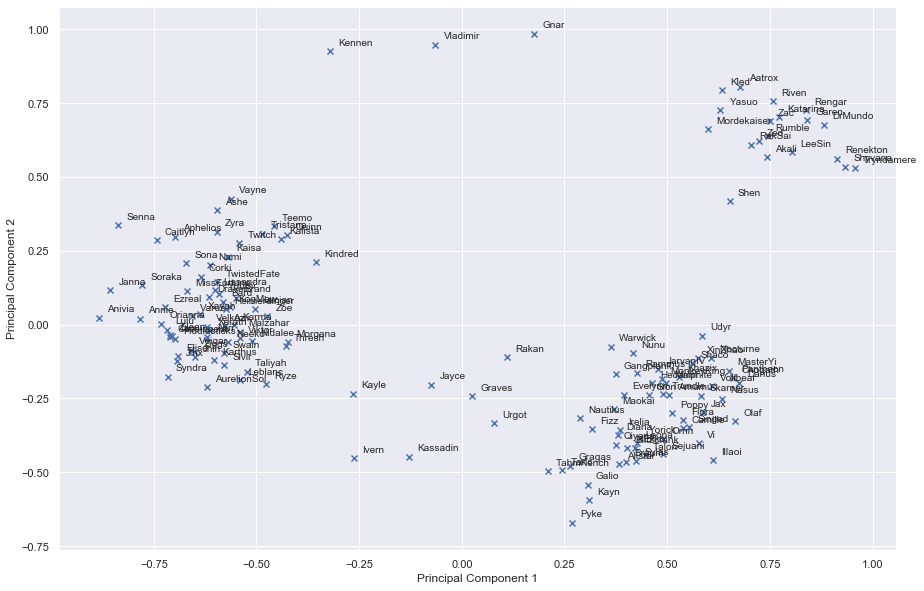

In [223]:
# plotting with minmax scaling
plt.figure(figsize = (15,10))

for i, type in enumerate(final_df['key']):
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    plt.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    plt.text(x_axis + 0.02 , y_axis + 0.02, type, fontsize = 10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

In [211]:
teemo = 'D:/Python/league_of_legends/images/Teemo.png'
img = mpimg.imread(teemo)

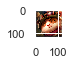

In [216]:
plt.figure(figsize=(0.5, 0.5))
plt.imshow(img);

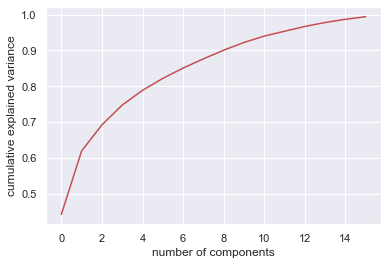

In [198]:
# what if I wanted to know how many components it would take to have 99% explained variance?
pca = PCA(n_components = 0.99, svd_solver = 'full')
principal_components_minmax = pca.fit_transform(x_minmax)

plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show();

In [199]:
# performing the same steps using robust scaler
x_robust = RobustScaler().fit_transform(x)

# pca projection into 2D
pca = PCA(n_components = 2)
principal_components_robust = pca.fit_transform(x_robust)

print(pca.explained_variance_ratio_)

[0.80866401 0.05328993]


In [200]:
# inputting into df for plotting
principal_df = pd.DataFrame(data = principal_components_robust, 
                           columns = ['principal component 1', 'principal component 2'])

# recombining champion names and components
final_df = pd.concat([principal_df, y], axis = 1)

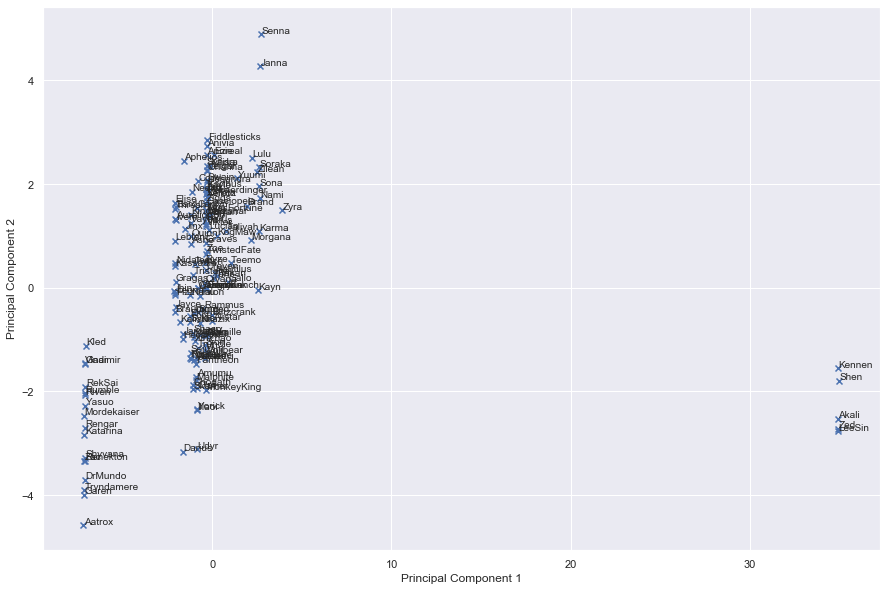

In [201]:
# plotting with robust scaling
plt.figure(figsize = (15,10))

for i, type in enumerate(final_df['key']):
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    plt.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    plt.text(x_axis + 0.02, y_axis + 0.02, type, fontsize = 10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

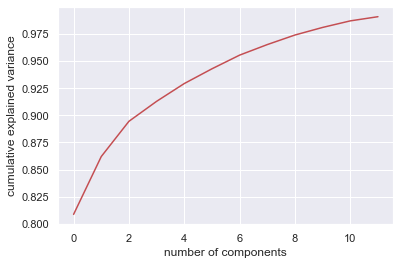

In [158]:
# what if I wanted to know how many components it would take to have 99% explained variance?
pca = PCA(n_components = 0.99, svd_solver = 'full')
principal_components_robust = pca.fit_transform(x_robust)

plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show();